# Import data

In [37]:
import pandas as pd
import numpy as np
import scipy as sci
import matplotlib as plt

df = pd.read_csv("Walmart_sales.csv")
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Data Cleaning 

## Converting Date column into date time


In [38]:
df["Date"] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
print(df.dtypes)
df.head()

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


# Data Exploration

## Individual Feature Exploration

### Stores

#### Taking a look at the number of stores

In [39]:
numStores = len(df["Store"].unique())
print("Number of Stores: " + str(numStores))

Number of Stores: 45


Clearly, we have a pretty large number of stores (around 10% of the stores in the US according to some quick research). 

#### Taking a look at the number of holiday's per store 

AxesSubplot(0.125,0.11;0.775x0.77)


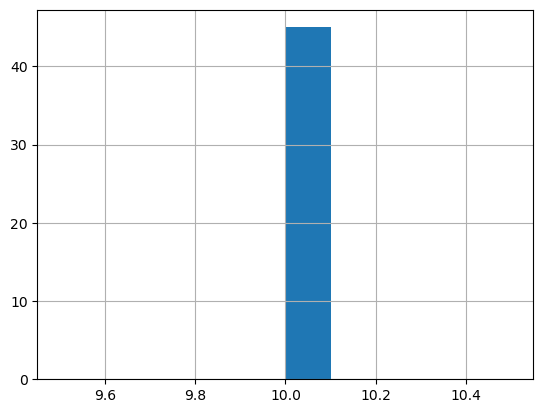

In [40]:
print(df[df["Holiday_Flag"] == 1].groupby("Store")["Holiday_Flag"].count().hist())

it looks like each store has exactly 10 holidays

#### Taking a look at the average sales per store

<AxesSubplot:>

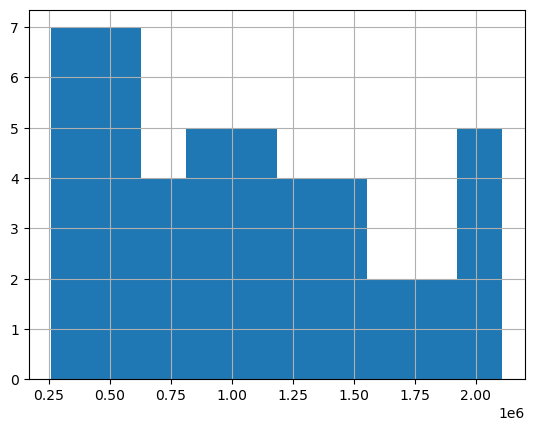

In [41]:

#avg sales per store differs 
df.groupby("Store")["Weekly_Sales"].mean().hist()

It seems like the average sales per store varies 

#### Taking a look at avg temperature per store 

<AxesSubplot:>

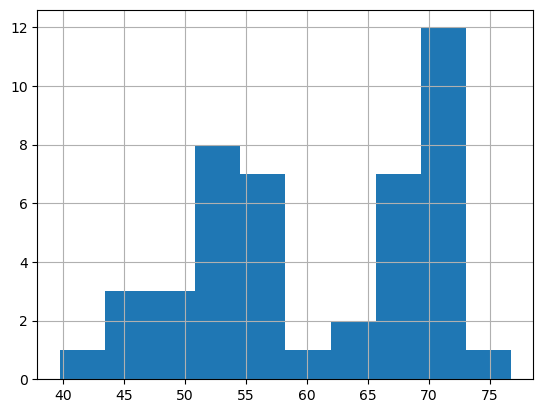

In [42]:
df.groupby("Store")["Temperature"].mean().hist()

The distribution of average temperature per store is bimodal with a peak around 52 degrees and another peak around 70 degrees. 

It seems like the stores are in different regions and/or that the dates for each store span different time frames. 

Spoiler alert: when you take a look at average CPI per store it becomes clear that there is a temporal difference between stores. However, the geographic difference cannot be asserted. 

#### taking a look at average CPI per store 

<AxesSubplot:>

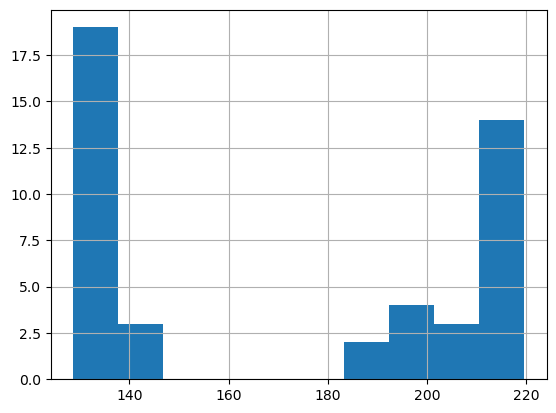

In [43]:
df.groupby("Store")["CPI"].mean().hist()

This supports the assertion that the stores come from different moments in time because CPI is fixed for each day. Thus, if the stores were all overlapping in time we'd see the same average for every store.

#### Taking a look at average unemployment rate per store

<AxesSubplot:>

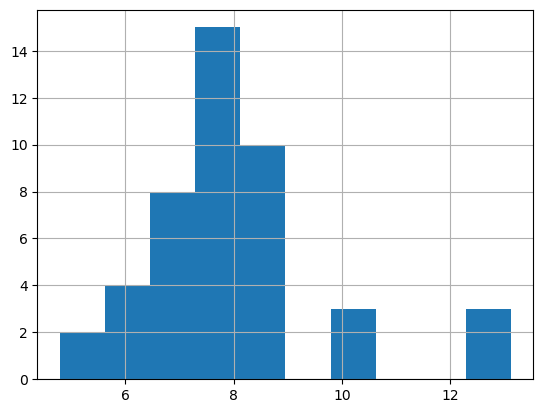

In [44]:
df.groupby("Store")["Unemployment"].mean().hist()

This once again supports the assertion that the data from these stores don't come from the same period of time. 

However, it is weird that the average unemployment rate per store and the avg CPI per store don't follow a similar distribution. This might be worth exploring.

#### Summary of findings after exploriing the Store column


##### Observed
- Stores aren't aligned in time. That is, the dates of their sales data differ. 
- Average sales per store differ. Different levels of performance. 
- every store has the same number of holidays
- there are 45 stores

##### Questions
- Are the stores in different regions?
- Why is the distribution of average unemployment rates different from the distribution of average CPI? 
    - Is unemployment rate local or national? 



### Date

The number of unique dates are: 143


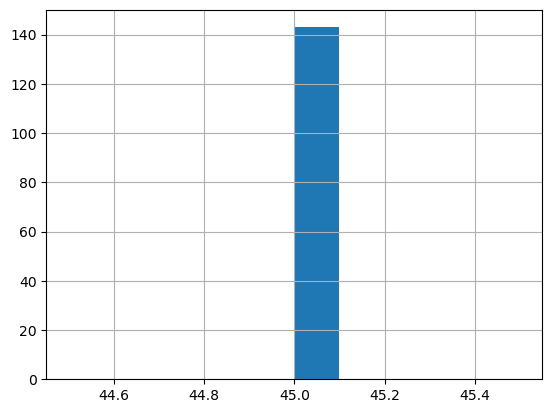

In [45]:
df.groupby("Date")["Date"].count().hist()
numUnique = len(df["Date"].unique())
print("The number of unique dates are: " + str(numUnique))

So we have 143 unique dates w/ each date having 45 corresponding instances 

<AxesSubplot:xlabel='Date'>

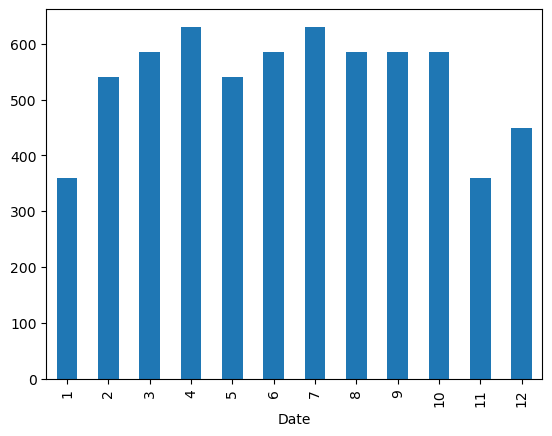

In [46]:
df.groupby(df["Date"].dt.month)["Date"].count().plot(kind="bar")

We do not have the same amount of data for each month of the year. So this again, supports the assertion that the data for each store is not set in the same time frame 

Now, lets take a look at the amount of data we have for each year

<AxesSubplot:xlabel='Date'>

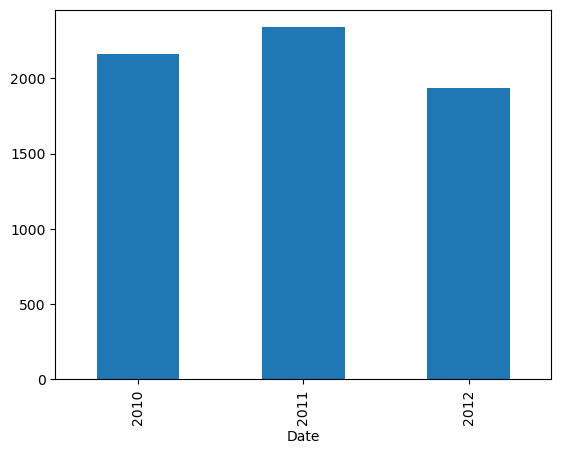

In [47]:
df.groupby(df["Date"].dt.year)["Date"].count().plot(kind="bar")

We have the most data on sales during 2011, then sales in 2010, and last sales in 2012

### Weekly Sales

Mean: 1046964.8775617732
Std Dev: 564366.6220536974


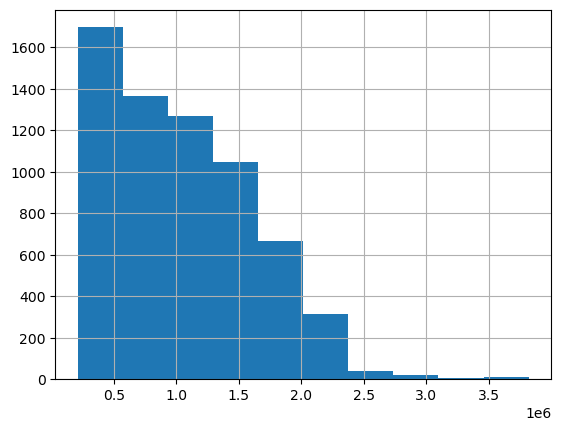

In [48]:
df["Weekly_Sales"].hist()
mean = df["Weekly_Sales"].mean()
stdDev = df["Weekly_Sales"].std()

print("Mean: " + str(mean))
print("Std Dev: " + str(stdDev))


This is a really weird distribution... why is the distribution this way? Does this have to do with how the sales data was collected, with the way walmart operates it's stores, or some other factor we cannot think of?

### Holiday Flag

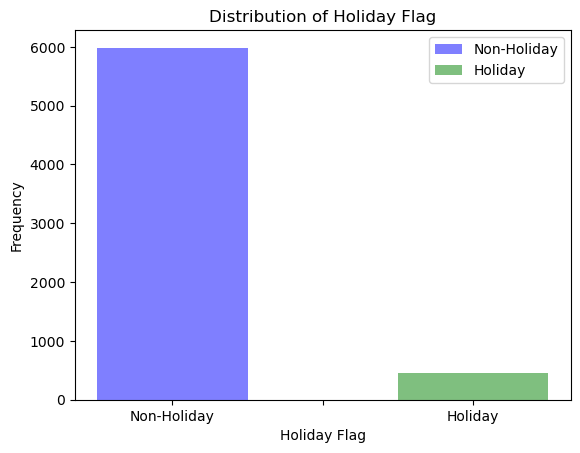

In [49]:
import matplotlib.pyplot as plt

# Define the bin edges to align with tick marks
bins = [-0.25, 0.25, 0.75, 1.25]

non_holiday = df[df['Holiday_Flag'] == 0]
holiday = df[df['Holiday_Flag'] == 1]

plt.hist(non_holiday['Holiday_Flag'], bins=bins, color='blue', label='Non-Holiday', alpha=0.5)
plt.hist(holiday['Holiday_Flag'], bins=bins, color='green', label='Holiday', alpha=0.5)

plt.xlabel('Holiday Flag')
plt.ylabel('Frequency')
plt.title('Distribution of Holiday Flag')
plt.legend()

# Customizing x-axis ticks and labels
plt.xticks([0, 0.5, 1], ['Non-Holiday', '', 'Holiday'])

plt.show()



From this analysis, we can infer that there is a very low percentage of weeks that are holidays. Consequently, holiday weeks, defined as 1, are expected to have a smaller effect on sales compared to holiday weeks. As, their lower holiday weeks vs. vs. holiday weeks in general, will be taking a look at the relationship between holidays and sales further below for stotres 1 - 4.

### Tempature

count    6435.000000
mean       60.663782
std        18.444933
min        -2.060000
25%        47.460000
50%        62.670000
75%        74.940000
max       100.140000
Name: Temperature, dtype: float64


<AxesSubplot:>

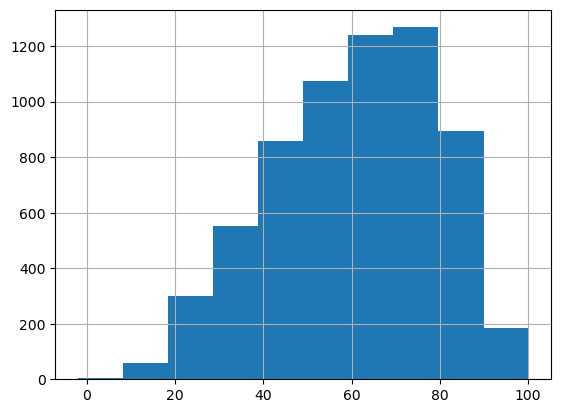

In [50]:
print(df["Temperature"].describe())
df["Temperature"].hist()

there is a large variation in temperatures. This could mean one of three things: 
- the stores are in different geographic locations 
- all the stores are not in different geograhic locations but rather they are all located in a region that sees both tempature extremes a year 
- **climate change** 

### Fuel Price

<AxesSubplot:>

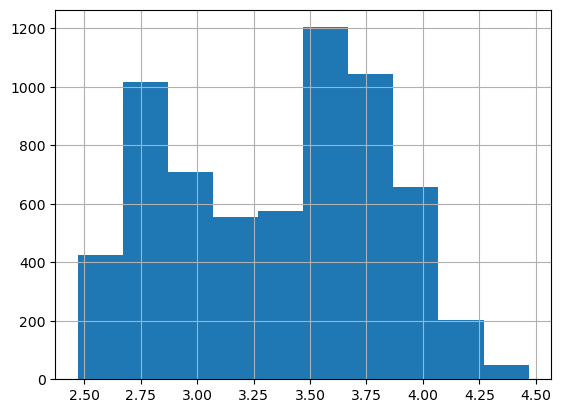

In [51]:
#view histogram for fuel price
df['Fuel_Price'].hist()

We have a bimodal distribution for our fuel prices 

In [52]:
#view summary statistics
mean = df['Fuel_Price'].mean()
stdDev = df['Fuel_Price'].std()


print(f"mean: {mean}")
print(f"Standard Devation: {stdDev}")


mean: 3.358606837606832
Standard Devation: 0.4590197071928516


### Consumer Price Index

<AxesSubplot:>

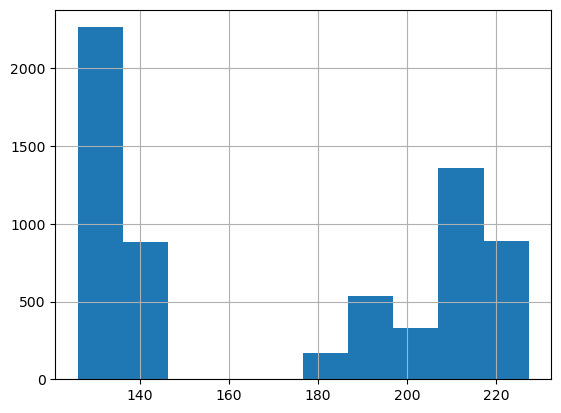

In [53]:
#view histogram
df['CPI'].hist()

it looks like we have a really weird discrete set of values. I wonder why there seems to be a chunk missing. From my understanding CPI is a continuous index that doesn't simply jump out like that. 

To dig deeper into why this occured let's look at CPI for each store (it should be roughly the same because the data is from the same time frame but it help determine the cause).  

<AxesSubplot:>

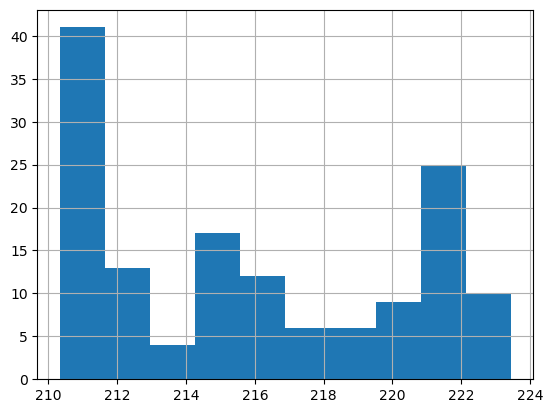

In [54]:
#histogram for store1
df[df['Store'] == 1]['CPI'].hist()

In [55]:
frame = df[df['Store'] == 1]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [210.3374261, 223.4442513]


It looks store 1 is continuous in the rough range [210, 223]

<AxesSubplot:>

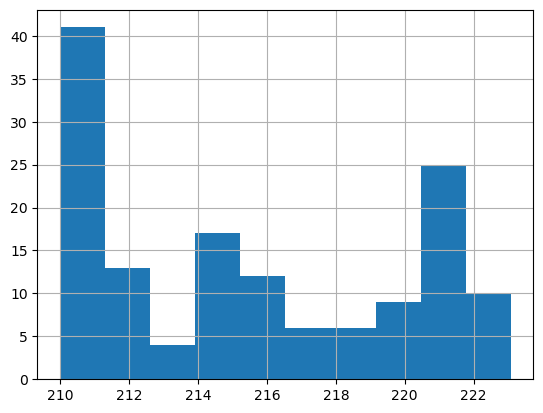

In [56]:
#view histogram of cpi for store 2
df[df['Store'] == 2]['CPI'].hist()


In [57]:
frame = df[df['Store'] == 2]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [209.9984585, 223.0783366]


Store 2's CPI values seem to be continuous in a very similar range as store 1

<AxesSubplot:>

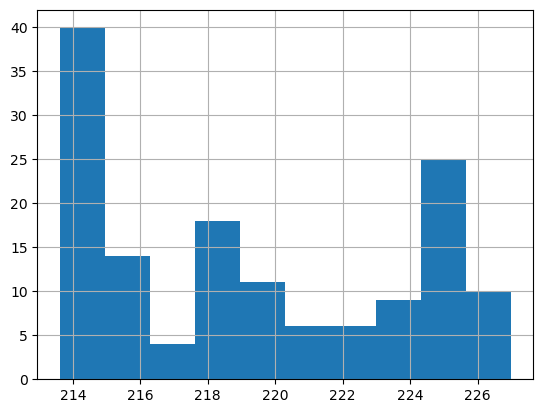

In [58]:
#view histogram of CPI's for store 3
df[df['Store'] == 3]['CPI'].hist()


In [59]:
frame = df[df['Store'] == 3]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")


Range: [213.6196139, 226.9873637]


Again, very similar range of CPI values. So, stores 1, 2, and 3 all have similar CPI ranges and store 4 seems to be an outlier in the CPI data

<AxesSubplot:>

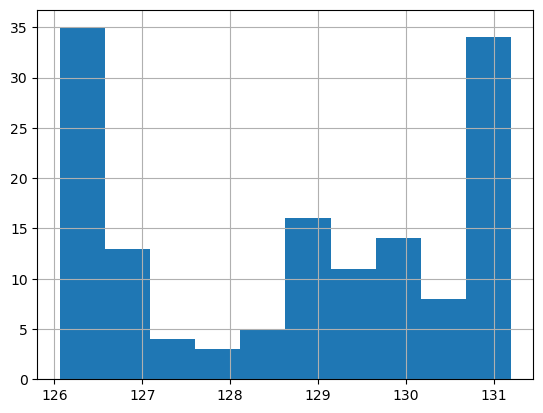

In [60]:
#view histogram of CPI values for store 4
df[df['Store'] == 4]['CPI'].hist()


In [61]:
frame = df[df['Store'] == 4]['CPI']
print(f"Range: [{frame.min()}, {frame.max()}]")

Range: [126.064, 131.1930968]


As suspected, store 4 is completely misasligned with the other stores in terms of it's CPI values. Hence, why we had that huge gap in data in the histogram of ALL CPI values. 

### Unemployment

<AxesSubplot:>

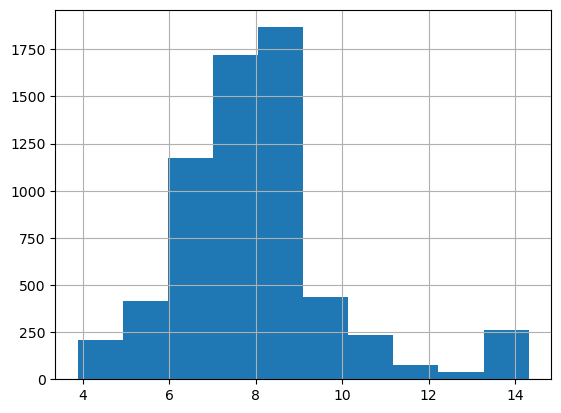

In [62]:
df['Unemployment'].hist()

## Feature vs Sales

### Tempature vs Sales

We want to use a hypothesis test to figure out whether temperature affects sales.

*Null Hypothesis*: The average temperature of the area has no effect on the sales.

*Alternative Hypothesis*: The average temperature of the area does have an effect on the sales.

Assume that we have a significance level of 0.05.

First, let's plot the stores, with their respective average temperature and weekly sales. We'll use a scatter plot, with each dot being a store from the set.

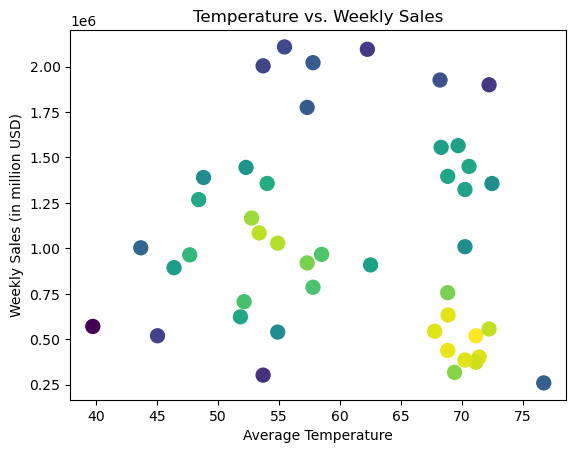

In [63]:
store_avgs = df.groupby("Store").mean("Temperature")

temp = store_avgs["Temperature"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Temperature vs. Weekly Sales")
plt.xlabel("Average Temperature")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

We can see that the stores are scattered around pretty evenly, with small clusters around the average temperature of 45-55 and 65-75 degree range.

Let's check the correlation between the two variables.

In [64]:
result = sci.stats.pearsonr(store_avgs["Temperature"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.07638774908646387, pvalue=0.6179663423198986)


Notice that the pearson correlation coefficient is -0.076, meaning that it is slightly negative. This means that as the average temperature increases, then the weekly sales decrease. Since the p value is larger than our alpha value (0.617), we fail to reject the null hypothesis. In other words, we can see that the average temperature does not have an effect on weekly sales.

### Fuel Price vs Sales

We can also use a hypothesis test to check if fuel prices have an effect on sales.

*Null Hypothesis: Fuel Prices do not have any effect on weekly sales.*

*Alternative Hypothesis: Fuel prices do have an effect on weekly sales.*

Assume alpha level as 0.05.

Let's first create a scatter plot graphing the correlation between fuel price and weekly sales.

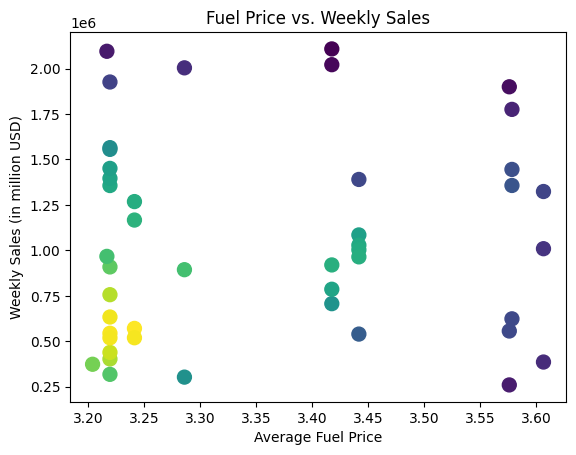

In [55]:
store_avgs = df.groupby("Store").mean("Fuel_Price")

temp = store_avgs["Fuel_Price"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Fuel Price vs. Weekly Sales")
plt.xlabel("Average Fuel Price")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

plt.show()

The fuel prices seem divided into three categories of prices, ranging from 3.20, 3.45, and 3.6 USD per gallon. With those three subdivisions, we can see that the weekly sales seem evenly spread out. From inspection, there looks like there's a very, VERY slight downard trend when the fuel price goes up.

Let's run a pearson correlation coefficient test to find out the correlation:

### CPI vs Sales

We want to use a hypothesis test to figure out whether cpi affects sales.

*Null Hypothesis*: The average cpi does no effect on the sales.

*Alternative Hypothesis*: The average cpi does have an effect on the sales.

Assume that we have a significance level of 0.05.

First, let's plot the stores, with their respective average cpi and weekly sales. We'll use a scatter plot, with each dot being a store from the set.

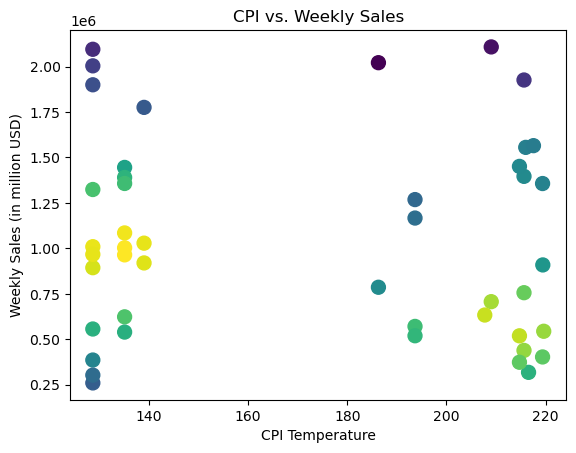

In [65]:
store_avgs = df.groupby("Store").mean("CPI")

temp = store_avgs["CPI"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("CPI vs. Weekly Sales")
plt.xlabel("CPI Temperature")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

We observe that the stores are divided into two groups: some stores cluster around 140 CPI on the left-hand side, while others cluster around 200 CPI on the right-hand side. Interestingly, there appears to be an even distribution of revenue among these points, indicating comparable sales performance across stores despite differences in CPI.

In [66]:
result = sci.stats.pearsonr(store_avgs["CPI"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.07656886071136423, pvalue=0.6171309899200206)


Notice that the Pearson correlation coefficient is -0.0765, indicating a slight negative correlation. This suggests that as the average CPI increases, weekly sales decrease. However, since the p-value is larger than our alpha value (0.617), we fail to reject the null hypothesis. In other words, we can conclude that the average CPI does not have a significant effect on weekly sales. This conclusion is supported by the scatter plot visualization, where no noticeable change in the relationship between average CPI and weekly sales is observed as CPI increases or decreases.

### Unemployment vs Sales

We want to now test if unemployment rates have an effect on the stores' average weekly sales.

*Null Hypothesis:* The unemployment rate has no effect on the stores' average weekly sales.

*Alternative Hypothesis:* The unemployment rate does have an effect on the stores' average weekly sales.

Assume that our significance level is 0.05.

We can graph a scatter plot of each store:

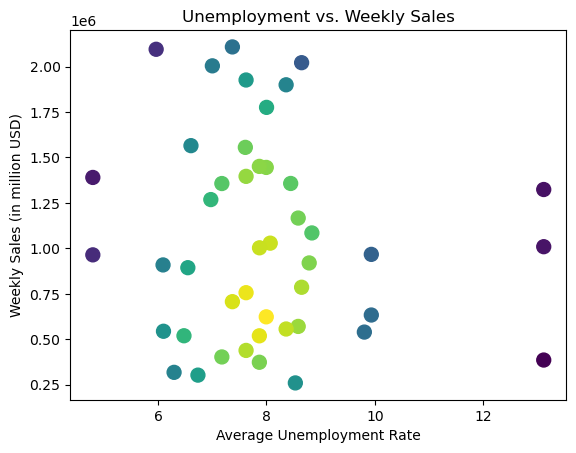

In [67]:
temp = store_avgs["Unemployment"]
sales = store_avgs["Weekly_Sales"]

ts = np.vstack([temp,sales])
z = sci.stats.gaussian_kde(ts)(ts)

fig, plot = plt.subplots()

plt.title("Unemployment vs. Weekly Sales")
plt.xlabel("Average Unemployment Rate")
plt.ylabel("Weekly Sales (in million USD)")

plot.scatter(temp, sales, c=z, s=100)

We can see that most of the stores' average unemployment rates are between 6-9 percent, with sales being scattered pretty evenly across the board.

Let's now check the correlation between the two variables:

In [68]:
result = sci.stats.pearsonr(store_avgs["Unemployment"], store_avgs["Weekly_Sales"], alternative="two-sided")

print(result)

PearsonRResult(statistic=-0.1122807976992151, pvalue=0.46274512845722776)


Notice that the correlation coefficient is -0.112, which is slightly negative. This means that as unemployment rates go up, the weekly sales will go slighly down. Since our p value is 0.46, which is greater than 0.05, we fail to reject the null hypothesis. In other words, the unemployment rate does not have an effect on weekly sales.

### Holiday vs Sales

Will be taking a look at the relationship between holidays and sales for stores 1 through 4, as we know from the Holiday flag, there is lower frequency of holiday weeks then non-holiday weeks.

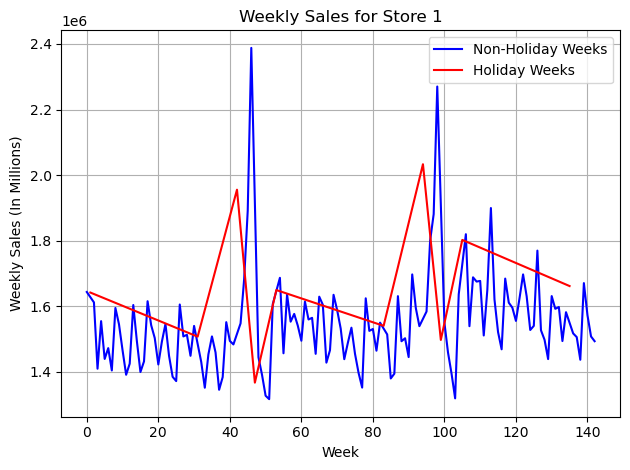

In [69]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_1 = df[(df['Store'] == 1) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_1.index, non_holiday_1['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_1.index, holiday_1['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales (In Millions)')
plt.title('Weekly Sales for Store 1')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

The interaction between the sales data during non-holiday and holiday weeks highlights the impact of holidays on consumer behavior and sales activity for Store 1, providing valuable insights for strategic decision-making in retail management

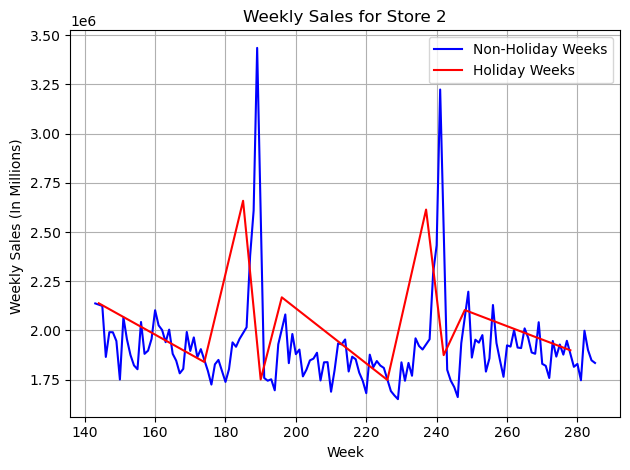

In [70]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_2 = df[(df['Store'] == 2) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_2.index, non_holiday_2['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_2.index, holiday_2['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales (In Millions) ')
plt.title('Weekly Sales for Store 2')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

In the second store, we notice that there is a significant difference in the total sales amount compared to store 1, which is much higher.

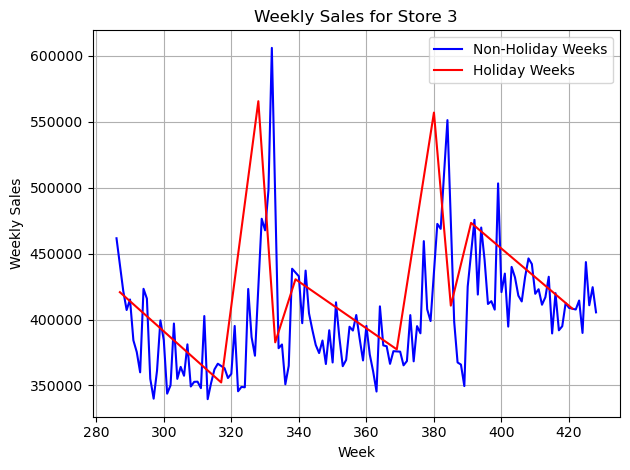

In [71]:
import matplotlib.pyplot as plt

# Store 3 with non-Holiday's
non_holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with holidays
holiday_3 = df[(df['Store'] == 3) & (df['Holiday_Flag'] == 1)].iloc[:140]


# Plot sales data for Store 1 during non-holiday weeks
plt.plot(non_holiday_3.index, non_holiday_3['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

# Plot sales data for Store 1 during holiday weeks
plt.plot(holiday_3.index, holiday_3['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales for Store 3')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 3 consistently reports among the lowest weekly sales figures compared to other stores. Despite occasional spikes during holidays, its sales performance falls significantly short of Stores 1 and 2, which achieve over 3 million and approximately 550k in total sales, respectively.

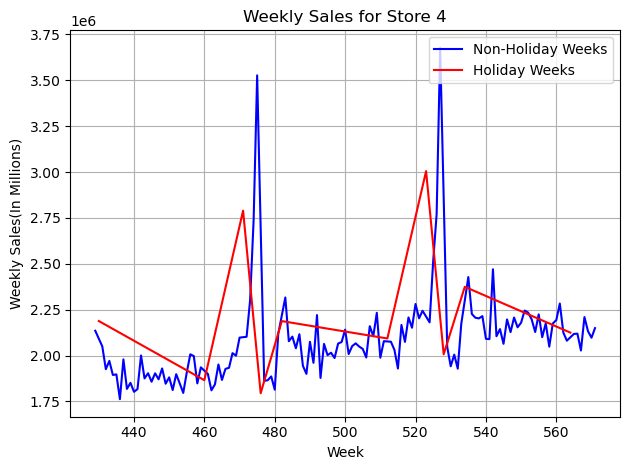

In [72]:
import matplotlib.pyplot as plt

# Store 4 with non-Holidays
non_holiday_4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 0)].iloc[:140]

# Store 4 with Holidays
holiday__4 = df[(df['Store'] == 4) & (df['Holiday_Flag'] == 1)].iloc[:140]

plt.plot(non_holiday_4.index, non_holiday_4['Weekly_Sales'], color='blue', label='Non-Holiday Weeks')

plt.plot(holiday__4.index, holiday__4['Weekly_Sales'], color='red', label='Holiday Weeks')

plt.xlabel('Week')
plt.ylabel('Weekly Sales(In Millions)')
plt.title('Weekly Sales for Store 4')
plt.legend()
plt.grid(True)  
plt.tight_layout()
plt.show()

Store 4 demonstrates consistent sales performance akin to that of Store 1 and Store 2. This observation suggests that Stores 1, 2, and 4 likely cater to a comparable population size and exhibit similar consumer foot traffic patterns, in contrast to Store 3.

Thus, from our analysis of stores 1 through 4, there is a similar spike in sales during holiday weeks, as shown from the visualization. This indicates that these stores will have higher revenue and a greater number of consumers visiting during these holiday weeks. Therefore, during these holiday weeks, these stores should continue to prioritize them since this is when they have the greatest revenue.